In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import os 
import json
from PIL import Image
import torch.utils.data as data
import torchvision.transforms.v2 as tfs
import torch.optim as optim
from tqdm import tqdm
from torchvision.datasets import ImageFolder

F.sigmoid(x) она от 0 до 1  
F.tanh(x) от -1 до 1 
обычно используются для нейронок с небольшим количеством слоев(до 10) либо в нейронах выходного слоя
потому что есть ровные(пологие) поверхности 

F.relu - используется чаще всего

Функции которые используются для выходных слоев 
- F.linear(x) - линейная, то что получаем то и выдаем, она не меняет входное значение
- F.softmax(x) - для много классовой классификации 
- F.sigmoid(x) - часто в бинарной классификации, можно интерпретировать как вероятность принадлежности к какому-то классу(потому что от 0 до 1)

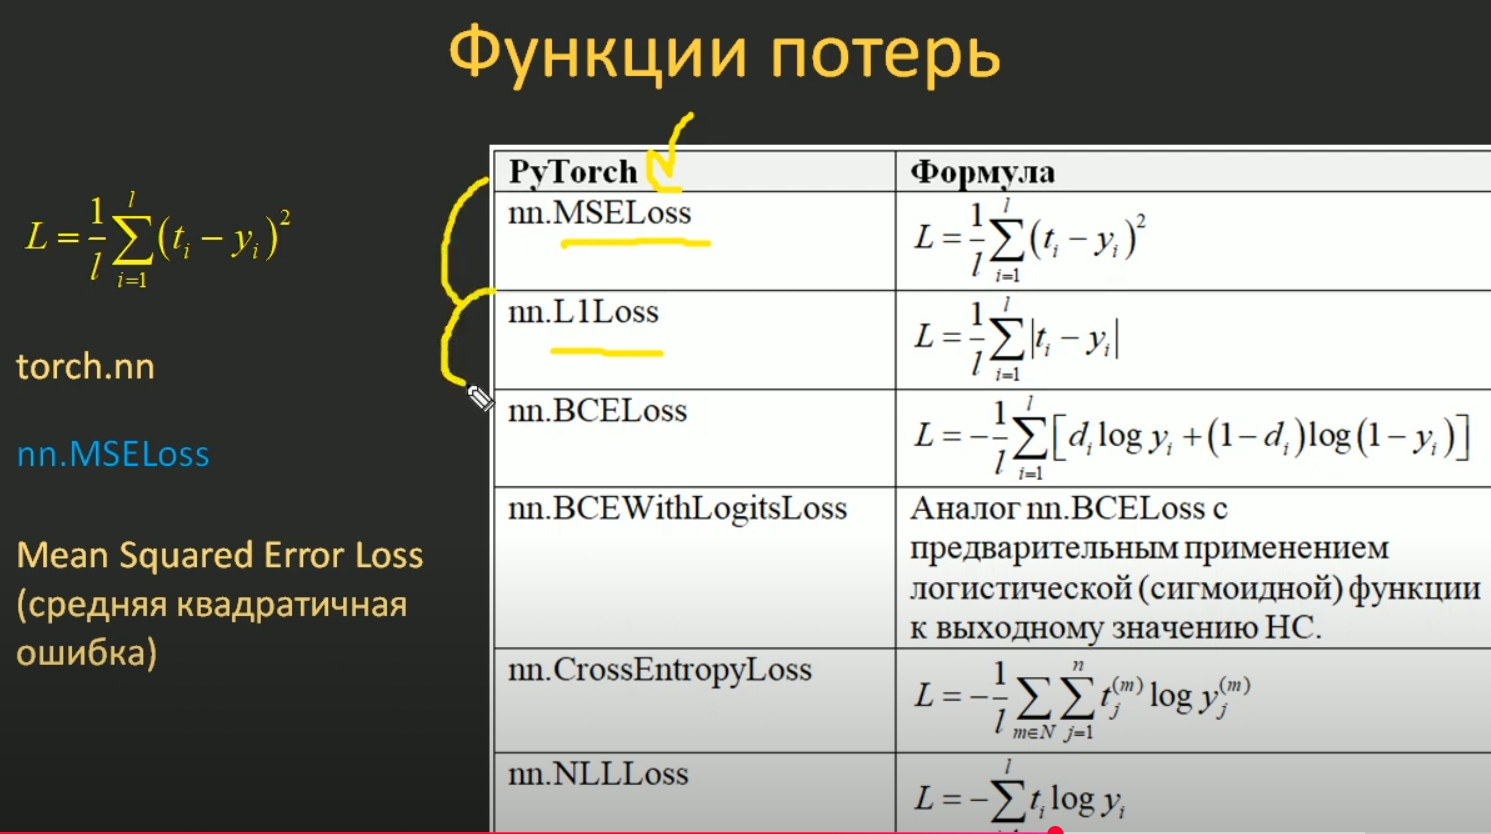

- BCELoss(Binarny Entropia Krzyżowa) - бинарная кросс энтропия
  - бинарная классификая
- CrossEntropyLoss(Krzyżowa Entropia Kategorialna) - перекрестная кросс энропия для много классовой
- NLLLoss(Strata Logarytmu Prawdopodobieństwa) - тоже для много классовой 

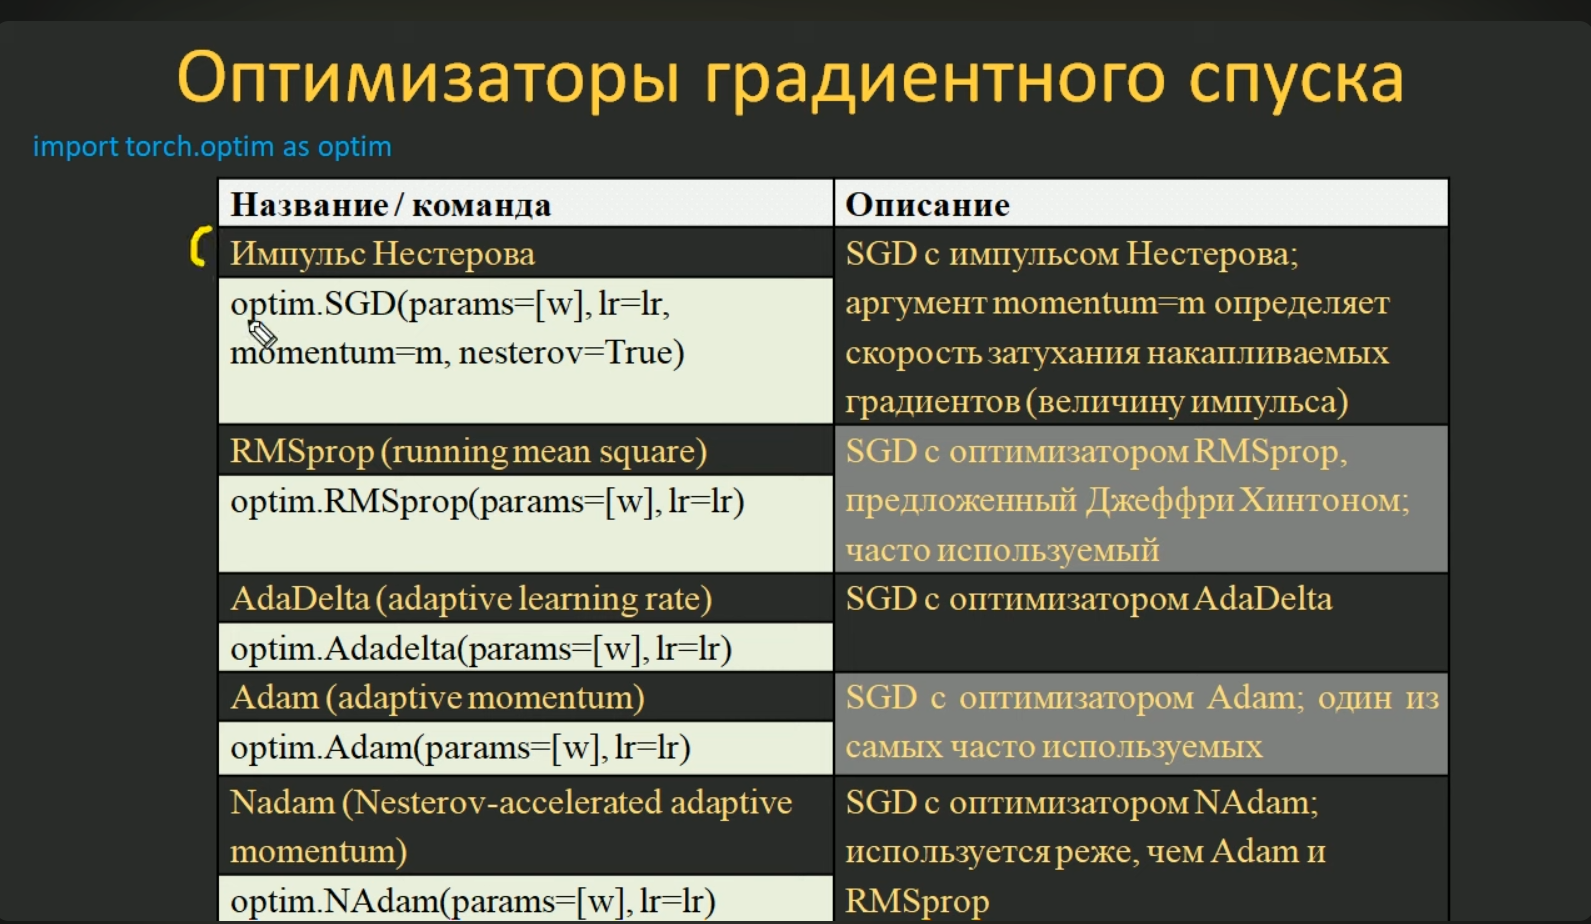

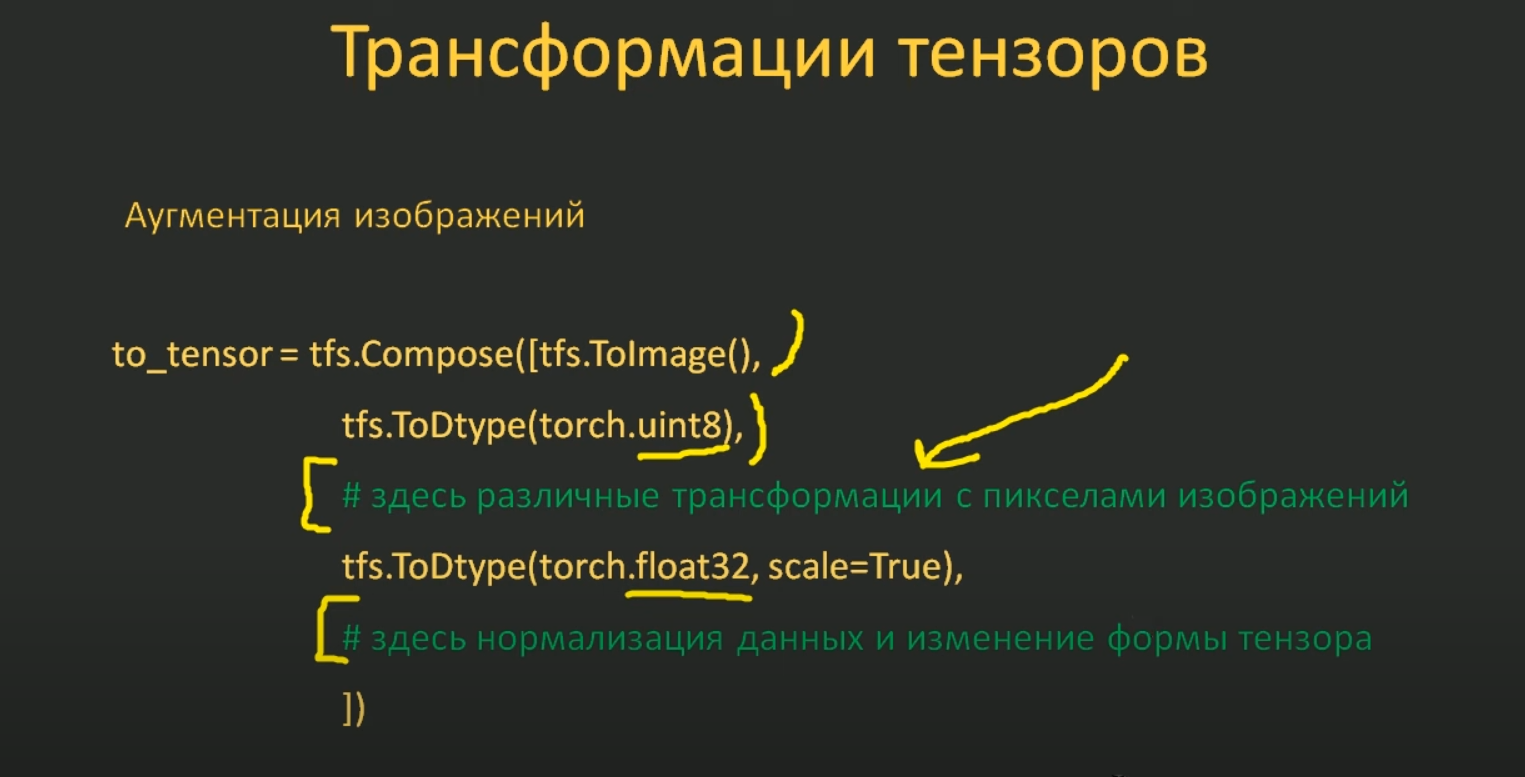

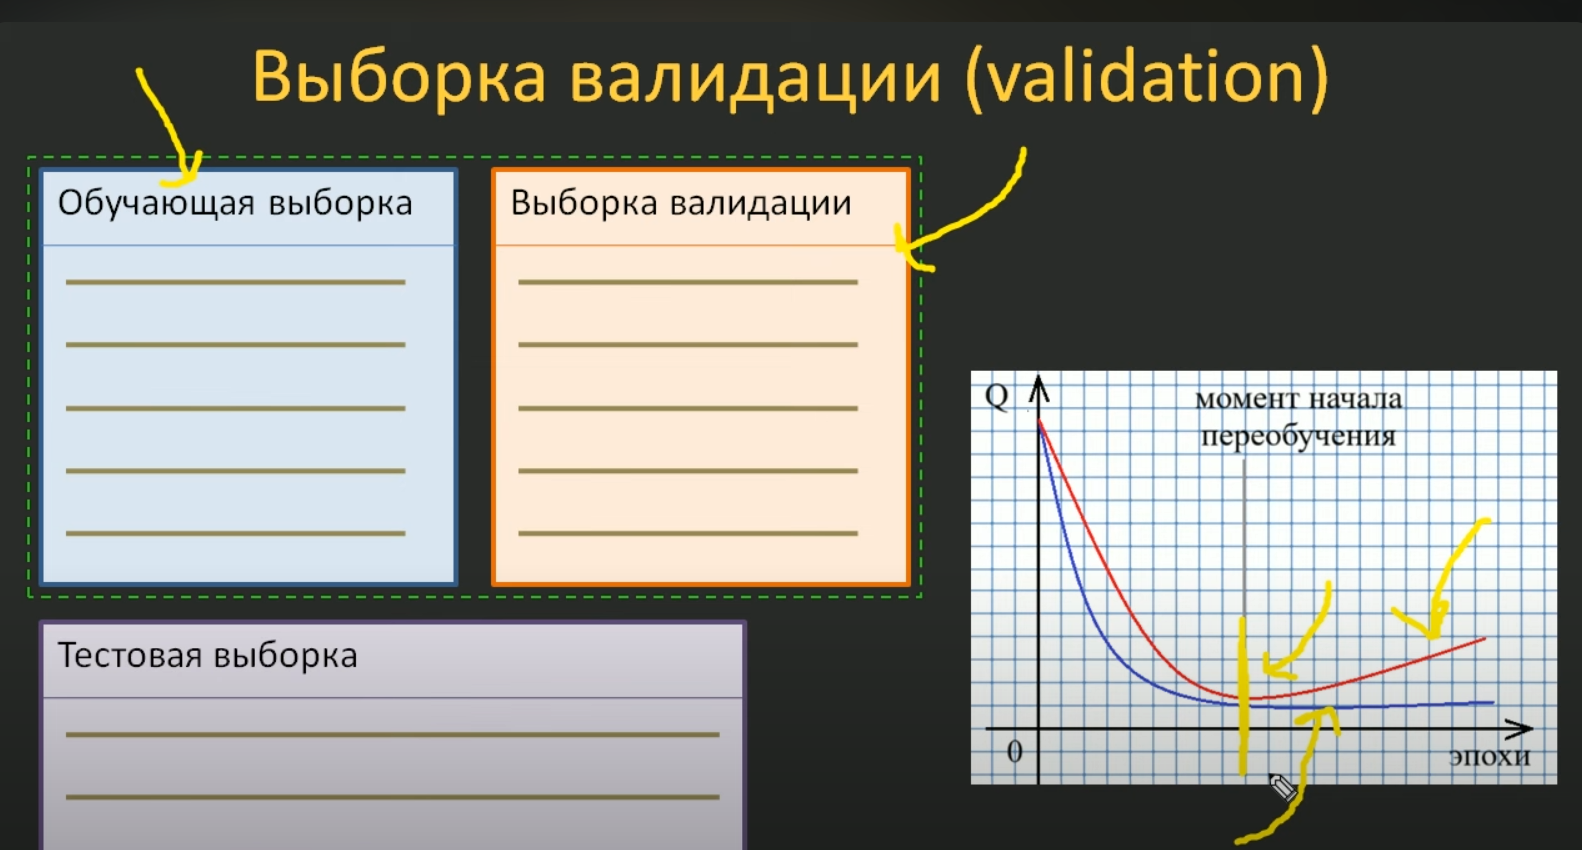

добавляется валидационная выборка(validation) которая служит для проверки процесса обучения, мы видим на графике (синяя - обучающая, красная - валидационная) если эти кривые расходятся значит идет процесс переобучения. 

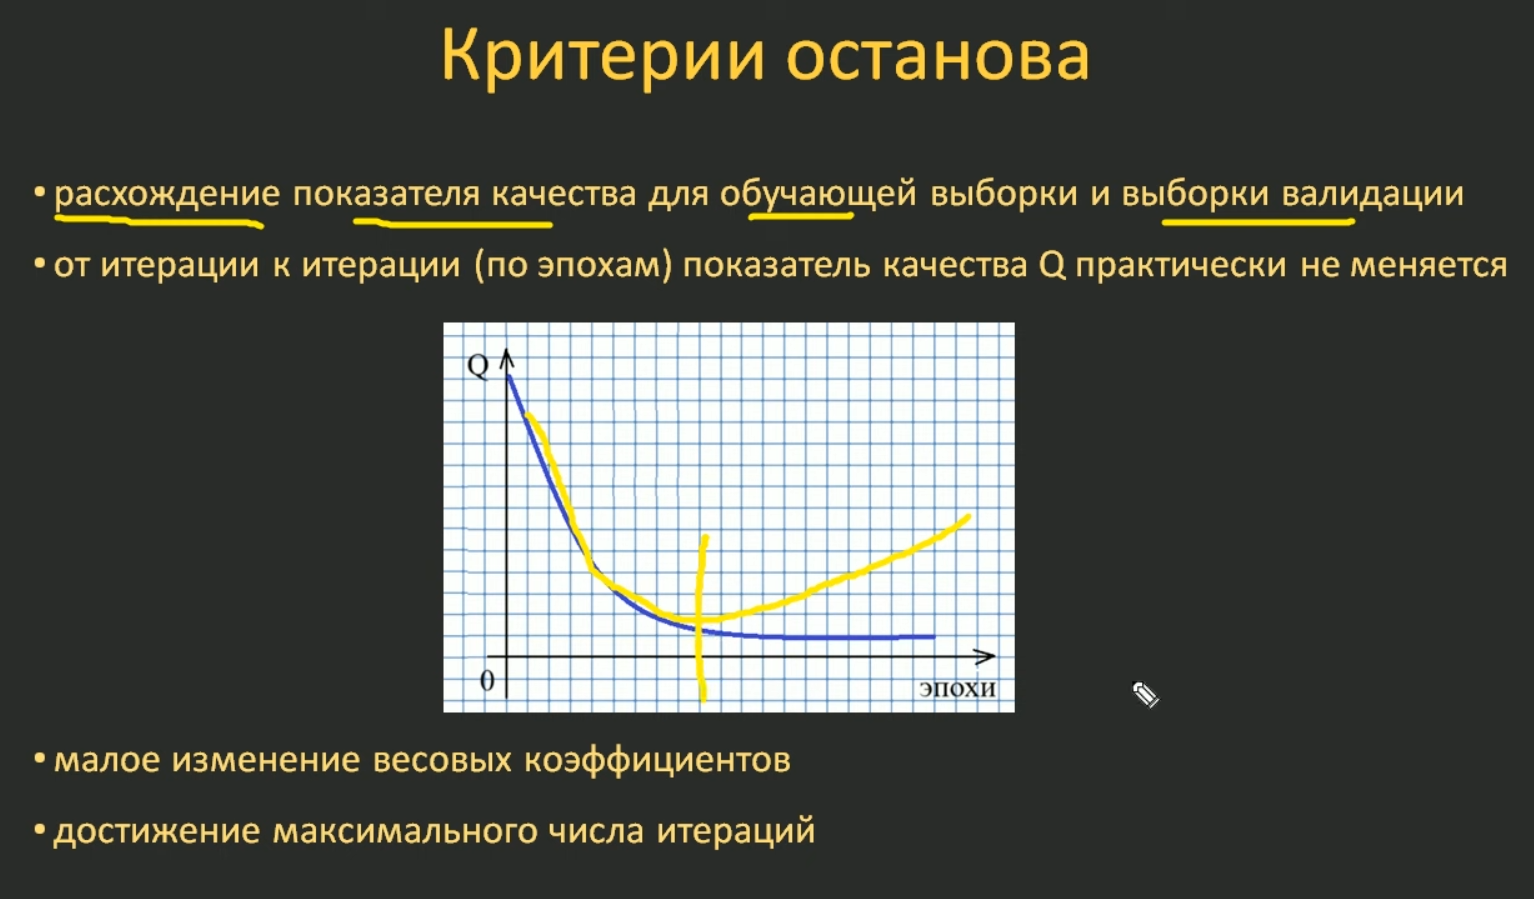

optim.Adam(params=model.parametrs(), lr=0.01, weight_decay=0.0001)
weight_decay - это и есть параметр регуляризации L2, если он не равен 0 то применяется L2

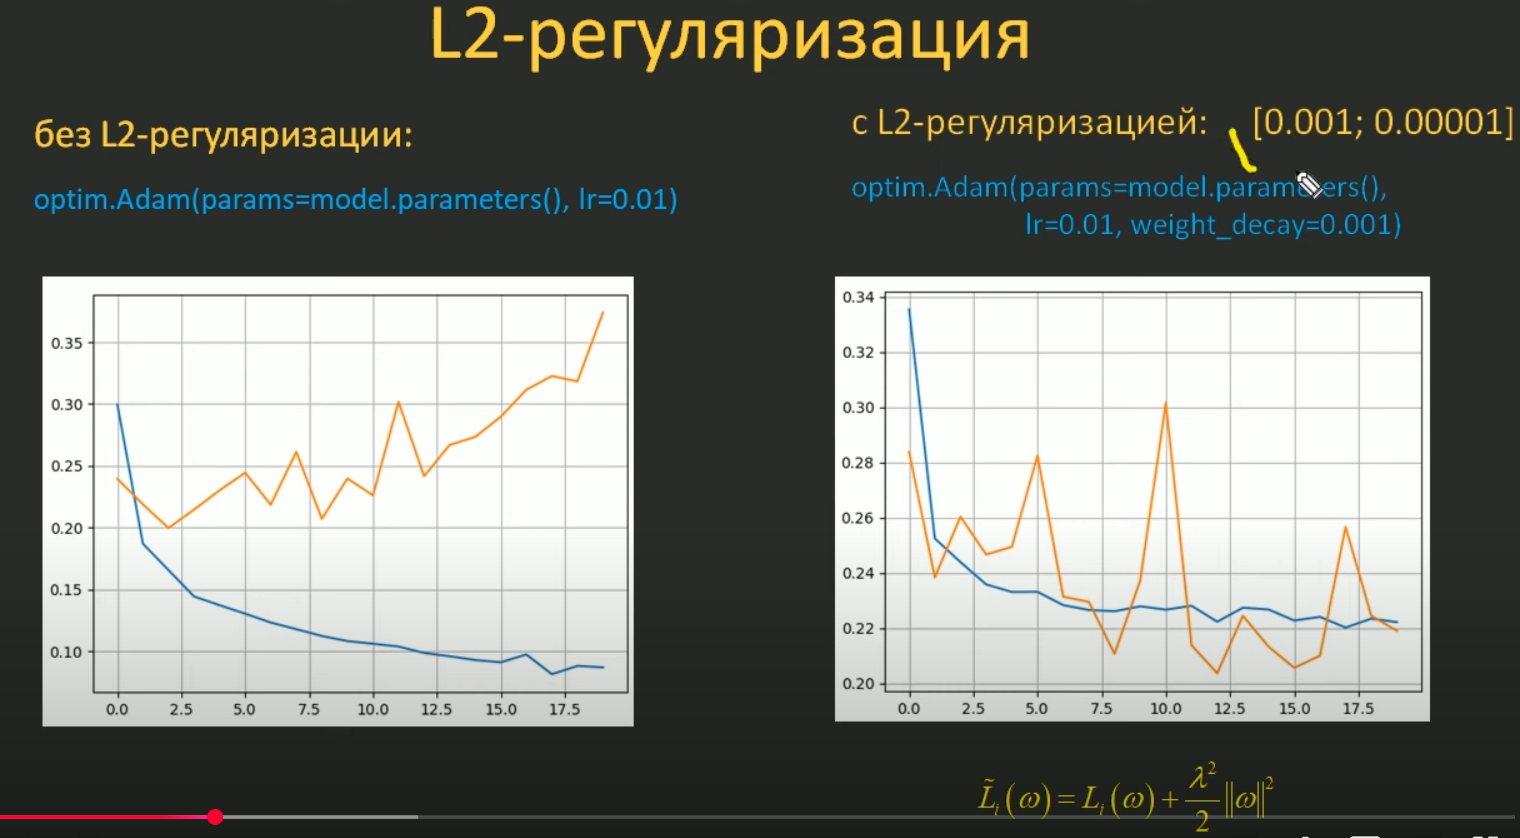


---

## Dropout

**Dropout** — это метод регуляризации, который случайным образом "выключает" некоторые нейроны во время обучения. Это помогает предотвратить переобучение и делает модель более устойчивой. Обычно прописывают после функции активации

### Как работает Dropout?
- **Во время обучения**:  
  🔹 Каждый нейрон отключается с вероятностью **p**.  
  🔹 Меньше нейронов участвует в вычислениях, что снижает активность сети.  

- **Во время тестирования**:  
  🔹 Все нейроны активны.  
  🔹 Их выходы домножаются на **(1 - p)**, чтобы сохранить средний уровень активности.

### Визуализация работы Dropout:
```python
import torch
import torch.nn as nn

dropout = nn.Dropout(p=0.5)  # 50% нейронов отключаются
x = torch.ones(10)  # входной тензор

print("До Dropout:", x)
print("После Dropout в обучающем режиме:", dropout(x))
```
---

# 🧠 Batch Normalization (Нормализация по мини-батчам / Normalizacja wsadowa)

## 📌 Проблема: Внутреннее изменение распределения  
**Internal Covariate Shift / Wewnętrzna zmiana rozkładu**  
- Распределение входных данных в скрытых слоях меняется во время обучения  
- Это замедляет обучение и делает сеть нестабильной  

## ✅ Решение: Batch Normalization  
1. Нормализует входные данные каждого слоя  
2. Ускоряет обучение  
3. Уменьшает зависимость от начальной инициализации  
4. Делает сеть более устойчивой  

## 🔬 Как работает?
- Для каждого нейрона в слое считаются среднее **(μ)** и стандартное отклонение **(σ)** по мини-батчу
- Нормализация
- Вводятся два параметра **(γ и β)** для управления масштабом и смещением
- Во время тестирования используются накопленные статистики  


Таким способом мы не можем посмореть что происходит в каждом слое отдельно:

In [3]:
model = nn.Sequential(
    nn.Linear(28 * 28, 32),
    nn.ReLU(),
    nn.Linear(32,10)
)
print(model)


Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=10, bias=True)
)


А таким методом можно рассмотреть каждый слой отдельно:

In [6]:
model = nn.Sequential()
model.add_module('layer_1', nn.Linear(28 * 28, 32))
model.add_module('relu', nn.ReLU())
model.add_module('layer_2', nn.Linear(32, 10))
print(model)

Sequential(
  (layer_1): Linear(in_features=784, out_features=32, bias=True)
  (relu): ReLU()
  (layer_2): Linear(in_features=32, out_features=10, bias=True)
)



---

### 1️⃣ **`nn.Module` (основа всего)**
Это базовый класс для всех нейросетей в PyTorch. Любая кастомная модель должна наследоваться от `nn.Module`.

#### 🔹 Как работает?
- Позволяет удобно строить нейросети, переопределяя метод `forward()`.
- Автоматически сохраняет параметры (`self.parameters()`).
- Позволяет переносить модель на GPU с `model.to(device)`.
- Автоматически отслеживает веса для градиентов.

#### 📌 **Пример**
```python
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = MyModel()
print(model)
```
> ✅ **Когда использовать?**  
> Всегда, когда создаёшь кастомную архитектуру нейросети.

---

### 2️⃣ **`nn.Sequential` (упрощённый способ создания моделей)**
- Это **контейнер**, который позволяет последовательно складывать слои без явного описания `forward()`.
- Очень удобен для простых нейросетей.

#### 📌 **Пример**
```python
model = nn.Sequential(
    nn.Linear(10, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)
print(model)
```
📌 Эквивалентно этой модели на `nn.Module`:
```python
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 5)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
```
> ✅ **Когда использовать?**  
> - Когда модель простая (например, MLP).  
> - Когда не нужно писать `forward()` вручную.

> ❌ **Когда НЕ использовать?**  
> - Когда есть ветвления или сложные архитектуры.  
> - Когда внутри `forward()` нужно что-то нестандартное.

---

### 3️⃣ **`nn.ModuleList` (список модулей)**
- Это **список слоёв**, который можно итерировать.
- В отличие от `Python list`, он правильно регистрирует параметры модели.
- Полезен, когда количество слоёв заранее неизвестно.

#### 📌 **Пример**
```python
layers = nn.ModuleList([nn.Linear(10, 10) for _ in range(3)])

for layer in layers:
    x = layer(x)  # Можно итерировать как список
```
📌 Аналог на обычном `list`:
```python
layers = [nn.Linear(10, 10) for _ in range(3)]
```
🔴 **Но если использовать просто `list`, PyTorch не будет отслеживать параметры внутри `layers`!**

> ✅ **Когда использовать?**  
> - Когда есть циклы (например, несколько одинаковых блоков).
> - Если заранее неизвестно количество слоёв.

> ❌ **Когда НЕ использовать?**  
> - Если у тебя фиксированная структура модели.

---

### 4️⃣ **`nn.ModuleDict` (словарь модулей)**
- Это **словарь слоёв**, который можно индексировать по строкам.
- В отличие от обычного `dict`, PyTorch отслеживает параметры.

#### 📌 **Пример**
```python
layers = nn.ModuleDict({
    'conv1': nn.Conv2d(1, 16, 3),
    'conv2': nn.Conv2d(16, 32, 3),
})

x = layers['conv1'](x)
x = layers['conv2'](x)
```
📌 Аналог на обычном `dict`:
```python
layers = {
    'conv1': nn.Conv2d(1, 16, 3),
    'conv2': nn.Conv2d(16, 32, 3),
}
```
🔴 **Но PyTorch не будет отслеживать параметры, если использовать обычный `dict`!**

> ✅ **Когда использовать?**  
> - Когда удобно обращаться к слоям по строковому ключу.
> - Когда разные слои нужны в зависимости от условий.

> ❌ **Когда НЕ использовать?**  
> - Если модель фиксированная, можно обойтись `nn.Module` или `nn.Sequential`.

---

### 🤔 **Что из этого тебе реально нужно для работы?**
1. **`nn.Module`** — **ВСЕГДА**, если пишешь кастомные модели.
2. **`nn.Sequential`** — если модель простая.
3. **`nn.ModuleList`** — если у тебя повторяющиеся слои в цикле.
4. **`nn.ModuleDict`** — если нужна гибкость в вызове слоёв.



---

## 🔹 **Почему PyTorch не вызывает `forward()` напрямую?**
Ты мог заметить, что мы пишем `model(x)`, а не `model.forward(x)`.  

🔴 **НЕПРАВИЛЬНО:**  
```python
output = model.forward(x)
```
✅ **ПРАВИЛЬНО:**  
```python
output = model(x) 
```
Почему?  
PyTorch перегружает `__call__()`, и когда ты вызываешь `model(x)`, он:
1. Добавляет доп. функциональность (`hooks`, автоград).
2. Затем вызывает `forward()`, но уже внутри себя.


✅ **Когда `nn.Sequential` НЕ поможет?**  
- Когда есть **разветвления в архитектуре**.  
- Когда надо **объединять выходы нескольких слоёв**.


## 🔥 **Вывод**
- `forward()` задаёт, как данные проходят через модель.
- PyTorch **автоматически вызывает его через `model(input)`**.
- `nn.Sequential` удобен для простых моделей, но для сложных нужно писать `forward()` вручную.
- В `forward()` можно использовать любые PyTorch-операции, а не только `nn.Linear`, `nn.Conv2d` и т. д.


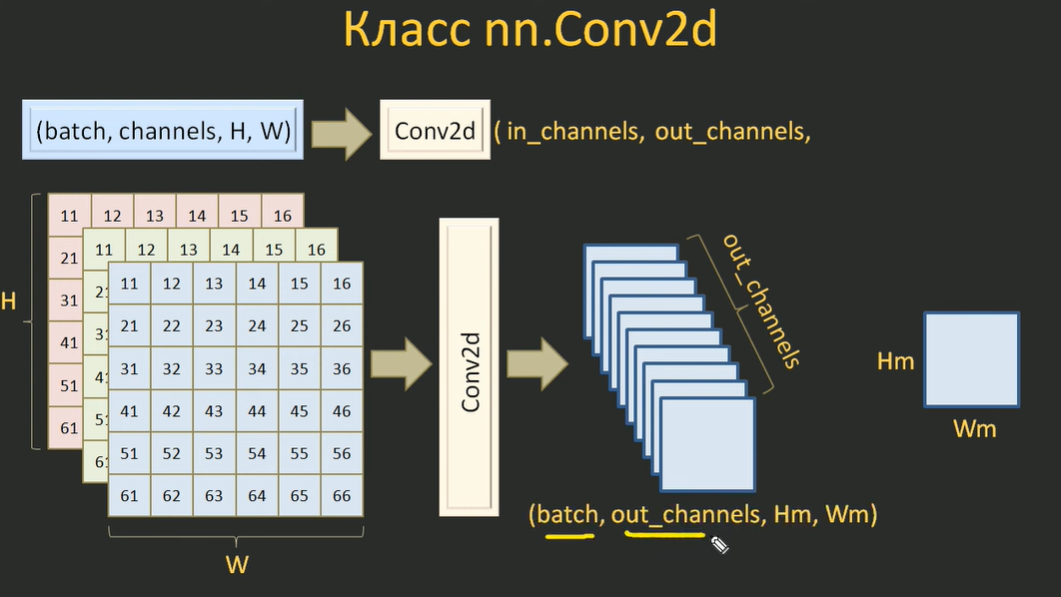

когда работаем уже с обученой моделью
```python
img = Image.open(os.path.join(path,f'sun_reg_{num_img}.png')).convert('RGB')
imt_t = transforms(img).unsqueeze(0)
```
unsqueeze(0) добавляет еще одну ось было (3 2 3) стало (1 3 2 3)
потому что модель привыкла получать еще параметр batch в начале 

---

# 🔁 Рекуррентная нейронная сеть (RNN)
### Recurrent Neural Network / Rekurencyjna sieć neuronowa

## 📌 Что это?
- Нейросеть, которая работает с **последовательными данными**  
- Умеет **запоминать** предыдущие шаги и использовать эту информацию  

> 🔹 В отличие от обычных нейросетей, RNN учитывает **контекст**  